# GFW Human Assets Access Tutorial

In [ ]:
!pip install -U odp-sdk --quiet && pip list | grep odp

## 1.1 Setup ODP Client

In [ ]:
from odp.client import OdpClient # The SDK
import pandas as pd
import pydeck as pdk

### 1.2.1 Pydeck Plot Helper

In [ ]:
from shapely import wkt

def convert_geometry_field(data):
    for item in data:
        try:
            geom = wkt.loads(item["geometry"])
            if geom.geom_type == "Point":
                item["geometry"] = {
                    "type": "Point",
                    "coordinates": [geom.x, geom.y]
                }
            elif geom.geom_type == "MultiLineString":
                item["geometry"] = {
                    "type": "MultiLineString",
                    "coordinates": [
                        [list(coord) for coord in line.coords]
                        for line in geom.geoms
                    ]
                }
            elif geom.geom_type == "LineString":
                item["geometry"] = {
                    "type": "LineString",
                    "coordinates": [list(coord) for coord in geom.coords]
                }

        except Exception as e:
            pass

    return data


### 1.2.2 Geometric Plot Helper

In [ ]:
# loading a simple function to make a nice map display of points
def simple_pydeck_plot(geojson_lists, size=1, lat=0, lon=0, zoom=2, fillopacity=0.9):
    colors = [(3, 255, 209), (157, 89, 244), (254, 119, 76), (255, 216, 11)]  # Cyan, Yellow, Purple, Orange
    layers = []
    for i, geojson_list in enumerate(geojson_lists):
        layer = pdk.Layer("GeoJsonLayer", data=convert_geometry_field(geojson_list), opacity=fillopacity, lineWidthMinPixels=size, pointRadiusMinPixels=size, pickable=True, get_line_color=colors[i % len(colors)], get_fill_color=colors[i % len(colors)],)
        layers.append(layer)
    r = pdk.Deck(layers=layers, initial_view_state=(pdk.ViewState(latitude=lat, longitude=lon, zoom=zoom)), map_provider="mapbox", map_style='mapbox://styles/oceandatafoundation/clwg6xklg00an01pcgmeufjxq', api_keys={'mapbox': 'pk.eyJ1Ijoib2NlYW5kYXRhZm91bmRhdGlvbiIsImEiOiJjazk5bGxpNWkwYWU1M2Vya3hkcHh4czdrIn0.yf7kIiPfDNE7KP9_9wTN6A'})
    return r

In [ ]:
client = OdpClient()

## 2.1 Fetch Metadata from Catalog
### Options:
- **Option 1**: Use API calls to the catalog.
- **Option 2**: Retrieve UUID from the landing page:
[GFW Offshore Human Assets Dataset](https://app.hubocean.earth/catalog/dataset/gfw-offshore-human-assets)
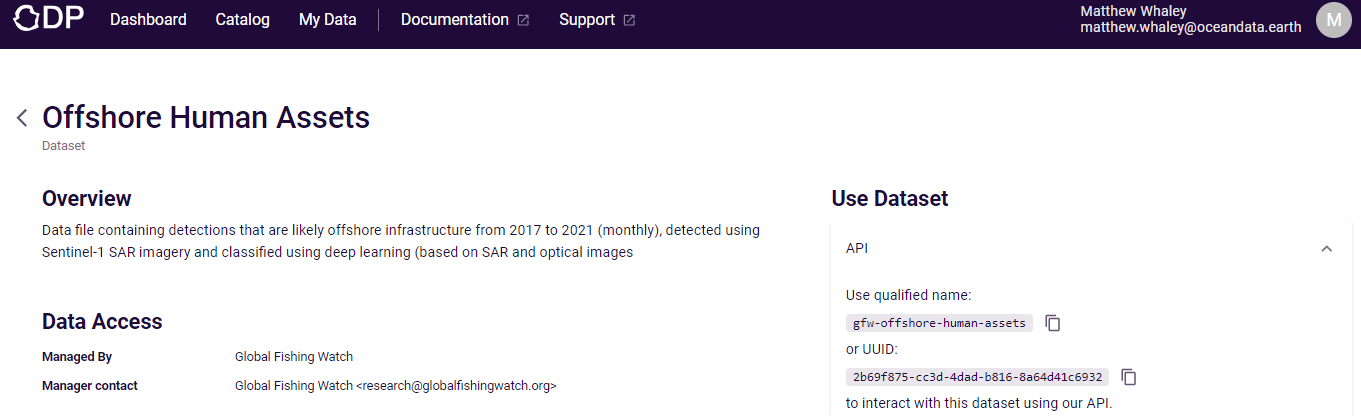

In [ ]:
HumanAssets = client.catalog.get("2b69f875-cc3d-4dad-b816-8a64d41c6932")
HumanAssets_dataset = client.table_v2(HumanAssets)
HumanAssets.metadata.display_name

## 2.2 Fetching Data

### 2.2.1 Fetching different rows based on the value in the *label* column

The data is returned as a *list of dictionaries*

In [ ]:
pages = list(HumanAssets_dataset.select('label == "wind"').pages())
HumanAssets_wind = [row for page in pages for row in page]

In [ ]:
pages = list(HumanAssets_dataset.select('label == "oil"').pages())
HumanAssets_oil = [row for page in pages for row in page]

In [ ]:
pages = list(HumanAssets_dataset.select('label == "unknown"').pages())
HumanAssets_unknown = [row for page in pages for row in page]

In [ ]:
print(f"Wind: {len(HumanAssets_wind)}")
print(f"Oil: {len(HumanAssets_oil)}")
print(f"Unknown: {len(HumanAssets_unknown)}")

## 3.1 Visualize data

Pydeck is unable to handle tens of thousands of points, so a sample of each of the data is taken and plotted

In [ ]:
import random

sampled_wind = random.sample(HumanAssets_wind, 5000)
sampled_oil = random.sample(HumanAssets_oil, 5000)
sampled_unknown = random.sample(HumanAssets_unknown, 5000)


### 3.2 Plots the wind, oil and unknown installation in an interactive map

In [ ]:
simple_pydeck_plot([sampled_wind, sampled_oil, sampled_unknown], size=1, lat=55, lon=7, zoom=1, fillopacity=1)

## 4.1 Inspect data


### 4.1.1 Option 1): work with list of datapoints


In [ ]:
#inspecting the fifth item of the list (numbering starts from 0)
HumanAssets_oil[4:6]

### 4.1.2 Option 2): convert from the list to a pandas dataframe

In [ ]:
pd.DataFrame(HumanAssets_oil).head()

## 5.1 Test a geospatial query of a bounding box

### 5.1.1 create bounding box for query

In [ ]:
from shapely.geometry import box, LineString, mapping
import shapely.wkt as wkt

bbox_lat_min = 59
bbox_lat_max = 61
bbox_lon_min = 2
bbox_lon_max = 7

geospatial_query = box(
    bbox_lon_min, bbox_lat_min,
    bbox_lon_max, bbox_lat_max
).wkt

### 5.1.2 Turn the bounding box queried by into a format the can be plotted by the pydeck function to show the bounding box.

In [ ]:
bbox_geom = box(bbox_lon_min, bbox_lat_min, bbox_lon_max, bbox_lat_max)

coords = list(bbox_geom.exterior.coords)

lines = [
    LineString([coords[0], coords[1]]),  # bottom
    LineString([coords[1], coords[2]]),  # right
    LineString([coords[2], coords[3]]),  # top
    LineString([coords[3], coords[0]])   # left
]

bbox_list = [
    {
        "type": "Feature",
        "geometry": mapping(line),
        "properties": {"edge": i}
    }
    for i, line in enumerate(lines)
]


### 5.2.1 Query the data based on a bounding box

In [ ]:
pages = list(
    HumanAssets_dataset
      .select(f"geometry within '{geospatial_query}'")
      .pages()
)

HumanAssets_subset = [row for page in pages for row in page]


### 5.2.2 plot the data and bounding box

In [ ]:
simple_pydeck_plot([HumanAssets_subset, bbox_list], size=2, lat=60, lon=5, zoom=5)